# Computer Vision - P3
# First part


## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **English**.

- The deliverable of both parts must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): October 26th, 23:00 h** 

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics of Laboratory 3 are:

First part: Video Segmentation:

3.1. Segmentation of video shots with static scenes.

3.2. Background subtraction.

Second part: Image Segmentation:

3.3. Segmentation of images.

To successfuly complete this practicum it is necessary to understand the following theory concepts: video segmentation, background subtraction, K-means clustering, different image segmentation approaches,...

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.



## Video segmentation

Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, we ask you to:
- Find the temporal segments of the video (shots). Where the scene change? (Section 3.1)
- Extract the background images and thus, remove all the "artifacts" considered as foreground related to movement. (Section 3.2)


Note: One of the applications of the backgroun subtraction methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras. Today, most of videoconference tools allow to put a virtual background. Thus, they need to extract the person (the foreground) and to put it on the new virtual background.


In [2]:
'''
DEFINITION OF HELPER FUNCTIONS

IN ORDER TO RUN THE REST OF THE EXERCISES THIS CELL MUST BE EXECUTED

'''
import math
import matplotlib
%matplotlib inline

# Function used to print image details
def print_im_detail(image):
    print('Type: ', image.dtype, ' Min.value: ', image.min(), ' Max.value: ', image.max(), ' Image shape: ', image.shape)
    
    
# Wrapper function to easily use subplot    
def print_images(images, titles=None, ncols=None, colormap=None):
    if ncols == None: #If no number of columns is given, we will print everything in one row
        ncols = len(images)
    if titles == None or len(titles) != len(images): #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in range(len(images))]
    
    nrows = math.ceil(len(images)/ncols) #Compute the number of rows required to print everythong in ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(13,13)) #Generate subplot
    
    #Switch off every axis
    for x in ax.ravel():
        x.axis("off")
        
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols + j >= len(images): #Stop if every image has been printed, even if the grid is not "complete"
                break;
            ax[i,j].imshow(images[i*ncols + j], cmap=colormap) #Set subplot with given colormap
            ax[i,j].set_title(titles[i*ncols + j])
    plt.show() #Show subplots
    return

#Helper function to easily print combined channel histograms
def print_histogram(images, titles=None, n_bins=32, size=(18,8)):
    if titles == None or len(titles) != len(images):  #Empty titles if no titles given or dimension mismatch 
        titles = ["" for i in len(images)]
        
    for image, title in zip(images, titles):
        image_g = rgb2gray(image)
        hst_r, bins_r = histogram( img_as_float(image[:,:,0]), nbins=n_bins)
        hst_g, bins_g = histogram( img_as_float(image[:,:,1]), nbins=n_bins)
        hst_b, bins_b = histogram( img_as_float(image[:,:,2]), nbins=n_bins)
        hst_gs, bins_gs = histogram(image_g, nbins=n_bins)

        ind = np.arange(n_bins)

        fig = plt.figure(figsize=size)
        cl_r = plt.bar(ind, hst_r, 0.1, color='r')
        cl_g = plt.bar(ind+.1, hst_g,0.1, color='g')
        cl_b = plt.bar(ind+.2, hst_b,0.1, color='b')
        cl_gs = plt.bar(ind+.3, hst_gs,0.1, color='y')
        plt.legend((cl_r[0], cl_g[0], cl_b[0],cl_gs[0]), ('Red','Green','Blue', 'Gray'), loc=1, prop={'size': 20})
        plt.title(title)
        plt.show()
    return

def print_frame_histogram(img, n_bins, title="", size=(18,8)):
    image_g = rgb2gray(img)
    hst_r, bins_r = histogram( img_as_float(img[:,:,0]), nbins=n_bins)
    hst_g, bins_g = histogram( img_as_float(img[:,:,1]), nbins=n_bins)
    hst_b, bins_b = histogram( img_as_float(img[:,:,2]), nbins=n_bins)
    hst_gs, bins_gs = histogram(image_g, nbins=n_bins)

    ind = np.arange(n_bins)

    fig = plt.figure(figsize=size)
    cl_r = plt.bar(ind, hst_r, 0.1, color='r')
    cl_g = plt.bar(ind+.1, hst_g,0.1, color='g')
    cl_b = plt.bar(ind+.2, hst_b,0.1, color='b')
    cl_gs = plt.bar(ind+.3, hst_gs,0.1, color='y')
    plt.legend((cl_r[0], cl_g[0], cl_b[0],cl_gs[0]), ('Red','Green','Blue', 'Gray'), loc=1, prop={'size': 20})
    plt.title(title)
    plt.show()
    return 
    
def get_frame_hist(img, n_bins=8, concatenated=True):
    float_img = img_as_float(img)
    hst_r, bins_r = histogram(float_img[:,:,0], nbins=n_bins)
    hst_g, bins_g = histogram(float_img[:,:,1], nbins=n_bins)
    hst_b, bins_b = histogram(float_img[:,:,2], nbins=n_bins)
    
    if concatenated: 
        return np.concatenate((hst_r, hst_g, hst_b))
    else:
        return (hst_r, hst_g, hst_b)

## 3.1 Segmentation of video shots

Read and visualize the sequence of images "images/Barcelona-sequence".

Hint: In order to read a collection of images, we wil use the function [animation.FuncAnimation](https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html).

Observe in the following Example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


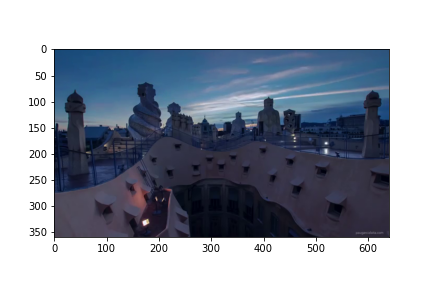

In [51]:
# Example
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder

%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!

fig = plt.figure()  # Create figure
im = plt.imshow(ic[0], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    im.set_array(ic[i*5]) #Changing the content of the canvas
    return im, #to return a tuple!

plt.show()
ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=True, frames=50, repeat= False)
plt.show()

a) Each of the scenes in a video is usually called 'shot'. Find where a shot (scene) finishes and the following starts (the shot boundaries). 

To solve this exercise, you need to create a **temporal plot** showing a frame by frame difference measure to be defined by you, being applicable to distinguish the shots. Define a criterion to detect the boundaries of the shots and visualize it in a static plot.

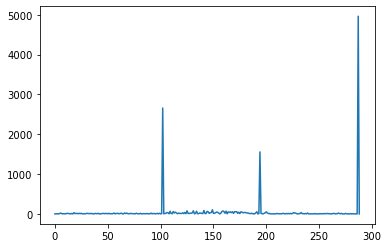

In [3]:
# Your solution here
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from skimage import img_as_float
from skimage.color import rgb2gray, rgba2rgb

%matplotlib inline

ic = io.ImageCollection('images/Barcelona-sequence/*.png')

#A la posició n hi ha el canvi entre la n i la n+1
'''
For each frame starting at the second, we add to diffs the median of the difference between frame and previous frame.
The n'th position of diff array contains the change between n and n+1 frames. We plot the differences and clearly see 
that there are 3 big spikes above 1000 (in absolute value). Those are the changes of scene.
'''

diffs = np.asarray([np.abs(np.median(get_frame_hist(ic[i-1]) - get_frame_hist(ic[i]))) for i in range(1, len(ic))])
plt.plot(diffs)
plt.show()


In [4]:
'''
We get the indexes of the spikes
'''
changes = np.where(diffs > 1000) 
print(changes[0])


[102 194 287]


Additionally, create an interactive plot executing the following code in "Example A". Substitute the bottom plot with the temporal plot showing the differences between the consecutive frames. 

<IPython.core.display.Javascript object>


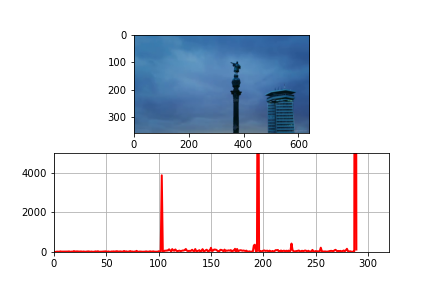

In [52]:
# Example A
# Sinusoidal plot points generation
%matplotlib nbagg

def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        y = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0


'''
Generator used to print te median of the difference of each frame
'''
def data_gen_hist_diff():
    t = data_gen_hist_diff.t
    hist = get_frame_hist(ic[0])
    for i in range(1, len(ic)):
        t += 1
        hist_prev = hist
        hist = get_frame_hist(ic[i])
        yield t, np.abs(np.median(hist_prev - hist))
                           
data_gen_hist_diff.t = 0



# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 5000)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen_hist_diff, blit=True, interval=5, repeat=False)
plt.show()

In case you used histograms to separate shots, use different bins to see what is the optimal size of the histogram to better separate the shots.

In [68]:
# Your solution here
'''
We have done tests with 2, 4, 8 and 16 bins. As the images are dark, with 2 bins the histograms are poralized and
most of the values are grouped together. When we calculate the difference between two frames we get lots of zeroes.
For this reason the median will almost be zero and we cannot identify changes between scenes. For a larger number of bins 
the contrary happens. The values are much more distributed so the values of the bins are lower. The difference 
will also be lower and we could miss the changes doing the median. The transition to the last scene is an example:
both frames contain lots of blue, so the difference is very distributed so we get a lower mean. We have found that medium 
values like 4 and 8 work the best.
'''
diffs = [[np.abs(np.median(get_frame_hist(ic[i-1], n_bins=bins) - get_frame_hist(ic[i], n_bins=bins))) for i in range(1, len(ic))] for bins in [2, 4, 8, 16]]

<IPython.core.display.Javascript object>


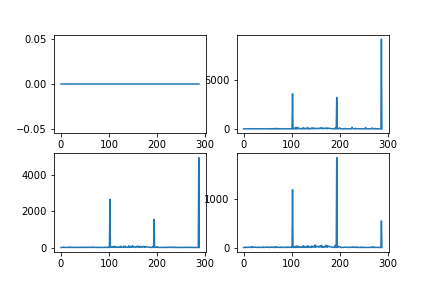

In [77]:
%matplotlib nbagg

fig, ax = plt.subplots(2,2)
ax[0,0].plot(diffs[0])
ax[0,1].plot(diffs[1])
ax[1,0].plot(diffs[2])
ax[1,1].plot(diffs[3])


b) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


**Hint:**
Use the previous plot to define the proper threshold value over the differences of histograms. Use the threshold to localize the initial and final frames.


102
194
287


<IPython.core.display.Javascript object>


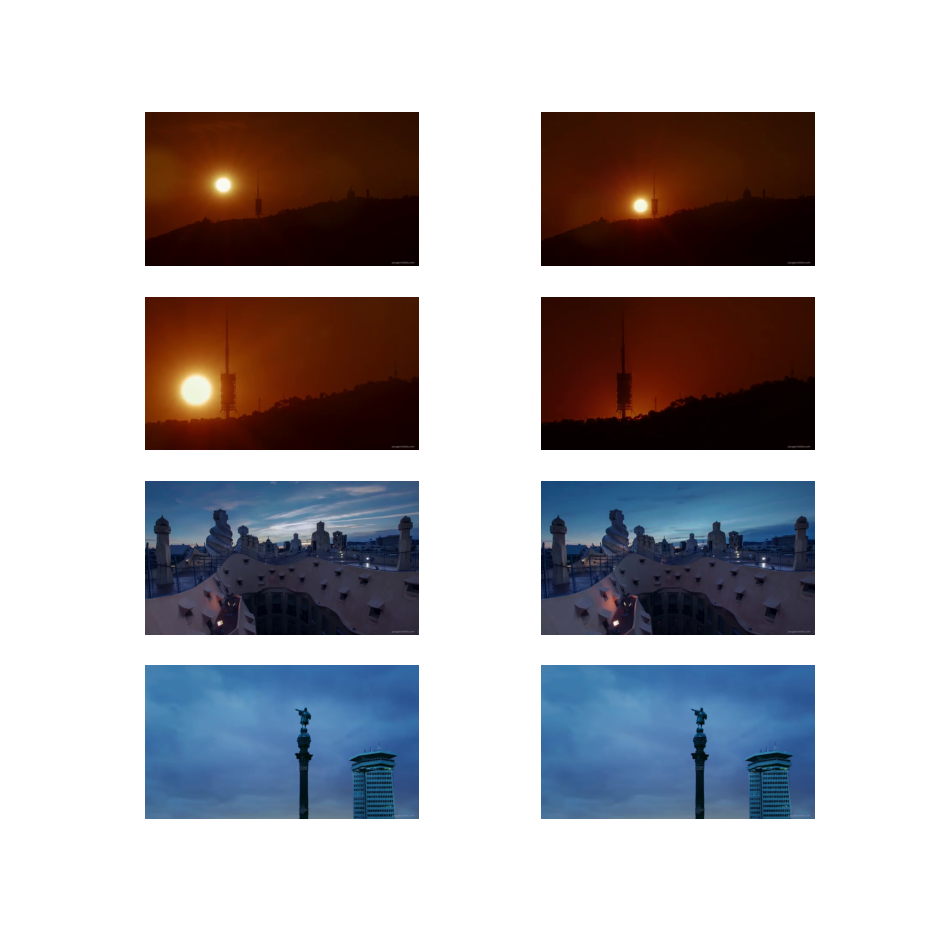

In [78]:
# Your solution here
'''
To get the different shots we add the first and last frames to the transitions vector.
In our solution we added the two last frames becouse we consider them a sequence and the histogram also detects it.
'''
alpha_omega = [ic[0]] #Adding first frame
for i in changes[0]: #For each change add the frame (the last of the sequence) and the next (the first of the next sequence)
    print(i)
    alpha_omega.append(ic[i])
    alpha_omega.append(ic[i+1])
alpha_omega.append(ic[-1]) #Adding last frame
    
print_images(alpha_omega, ncols=2)

c) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

In [77]:
# Your solution here
'''
We decided to use the absolute value of the median of the difference of histograms. Doing it this way assures that at least
half of the bins of the histogram have changed significantly. We take the absolute value after doing the median so the we get 
the full range of differences.
'''

d) Would your video segmentation strategy be able to separate and track objects? Argue your answer.

In [10]:
# Your solution here
'''
No, if the only change in the image is the position of an object, the histogram remains invariant, so we could not detect it. 
'''

e) Would your video segmentation strategy be able to capture continuous transition? Argue your answer.

In [11]:
# Your solution here
'''
No, for this to work (specialy since we are using the mediam) we need sudden changes in color/histogram. A smooth transition
would not generate these kind of changes.
'''

## 3.2 Background subtraction

Apply the background subtraction algorithm (check theory material).

a) Visualize the following images for each different scene (there are 3) of the video:

    1) an image belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

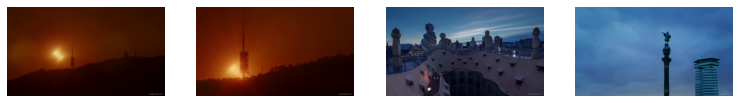

In [5]:
# Your solution here
def get_background(frames):
    return np.median(frames, axis=0).astype(int)

#Create a numpy array with all frames
frames = np.zeros((len(ic), ic[0].shape[0], ic[0].shape[1], ic[0].shape[2]))
for i in range(len(ic)):
    frames[i] = ic[i]

#Adding first and last frame to changes in order to have complete segments    
transitions = np.concatenate(([0], changes[0], [len(ic)-1])) 
backgrounds = []
for i in range(1,len(transitions)):
    #We have to sum 1 to the first index because otherwise the index gives us the last frame of the sequence
    backgrounds.append(get_background(ic[transitions[i-1]+1:transitions[i]])) 

print_images(backgrounds)
    

b) What do the static background images represent? 

In [13]:
# Your solution here
'''
The pixels of the background image are the median of the values. If a pixel remains unchanged at least 
half of the sequence the background pixel gets that value.
'''

c) What happens if the shots are not correctly extracted? And, what happens if you find too many shots in the video? 

In [14]:
# Your solution here
'''
If the sequence is not correctly extracted but only for a small number of frames in respect to the 
correct sequence, this shouldn't be a problem since we are using the median and won't affect much.

If we find too many shots, the obtained values won't be representative of the whole sequence.
'''

d) What happens if you subtract the background image from the original one?

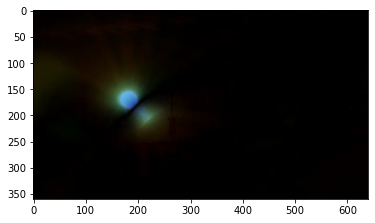

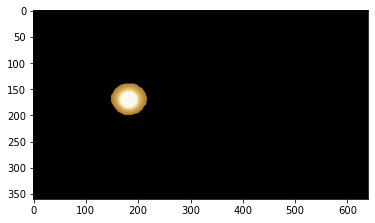

In [10]:
# Your solution here
%matplotlib inline
plt.imshow(abs(ic[2]-backgrounds[0]))
plt.show()

def get_foreground(image, background, threshold=0.5):
    #Assure the images are in the same format
    image = img_as_float(image)
    background = img_as_float(background)
    
    #Get the difference between the frame and the background and convert it to grayscale
    diff = rgb2gray(abs(image-background))
    #Mask to select the values that are avobe a certain threshold
    mask = diff > threshold

    #Create a new image to store foreground
    foreground = np.zeros(image.shape)
    #Every element of the background is sent to 0 and the elements of the foreground to the original values
    foreground[~mask] = 0 
    foreground[mask] = image[mask]
    
    return foreground
plt.imshow(get_foreground(ic[0], get_background(ic[0])))

e) In which situations does the algorithm work and in which it does not? Do you see any additional application for this algorithm?

In [11]:
# Your solution here
'''
The background should be static for each sequence. If everything moves the algorithm will consider everything as 
foreground. We also need abrupt transitions and, in general high differences in the distribution of 
colors across the spectrum.
'''


'\nThe background should be static for each sequence. If everything moves the algorithm will consider everything as \nforeground. We also need abrupt transitions and, in general high differences in the distribution of \ncolors across the spectrum.\n'

f) **[OPTIONAL]**
- Apply the algorithm to some other video that you found.

In [17]:
# Your solution here